# KSA: Polar Observations and Modelling

## Week 5 - Ship based in situ ocean observations

In `1_Introduction_to_CTDs.ipynb` we worked with a single CTD profile. Hopefully you now understand:

1. How the CTD files are structured, what dimensions and variables they contain
2. How to plot those variables, and calculate density using the `gsw` library.
3. How to compare sensor data with the water samples from the Niskin bottles.

In this notebook we are going to level up a bit, and look at a multiple different profiles from the same oceanographic voyage, the Multidisciplinary Investigations of the Southern Ocean [(MISO)](https://aappartnership.org.au/miso/). 

## Load libraries and data

We have imported a new library. *Use [CoPilot](https://copilot.microsoft.com/) to understand what it is used for.*

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import glob
import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.cm import ScalarMappable

First of all, we need to load all of our CTDs. Remember that to open, we need to use `xr.open(path_to_file)`. We have 22 different profiles in our `data` directory (sometimes you might have hundreds of files!), so instead of typing one by one, we will:

1. Use `glob` to create a list with the file names
2. Use `numpy` sort it in alphabetical order
3. Iterate through the list in order to open the CTD files and save them to a dictionary.

A dictionary is simply a collection of data callable by "keys". It allows to collect data that does not have the same size, shape or dimensions, which is useful for us since the CTD profiles have different depths, some are shallower and some go deeper.

In [12]:
# Create a list of paths
path_to_files = glob.glob('data/*Ctd*') 

In the above, the * serve as a wildcard. we're asking to list all the files that have `something Ctd something` in their name. This is because we have other files in our folder (HydroChem) which we'd like to ignore.

In [13]:
# Sort paths in descending order
path_to_files = np.sort(path_to_files)
# Initialise dictionary
CTDs = {}
# Iterate to open each file and save it to the dictionary
for i in range(0, len(path_to_files)):
    CTDs[i] = xr.open_dataset(path_to_files[i])

## Characterising our dataset 

We have opened a bunch of CTD profiles, but we don't know anything about them. We would like to know where these profiles where taken, and possibly also what day. This information is important to contextualise the data. 

### Location of profiles

Let's create a map where we can see the locations of all CTD profiles in our dataset. First, let's iterate to get (a) latitude, (b) longitude and (c) date information for each profile.

Create empty lists of lat, lon and data:

In [75]:
lat = []
lon = []
time = []

Iterate through the profiles, extract that information and append it to the list:

In [76]:
for i in range(0, len(CTDs)):
    lat.append(CTDs[i]['latitude'].values)
    lon.append(CTDs[i]['longitude'].values)
    time.append(CTDs[i]['time'].values)

The `.values` part extracts the value of that variable, and drops dimension and coordinate information as well as metadata. Compare:

In [34]:
CTDs[0]['latitude'].values

array([-66.47646332])

In [35]:
CTDs[0]['latitude']

<xarray.DataArray 'latitude' (latitude: 1)> Size: 8B
array([-66.476463])
Coordinates:
  * latitude  (latitude) float64 8B -66.48
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    data_min:       -66.4764633178711
    data_max:       -66.4764633178711
    valid_range:    [-90.  90.]

Now that we have extracted the information, let's plot the locations:

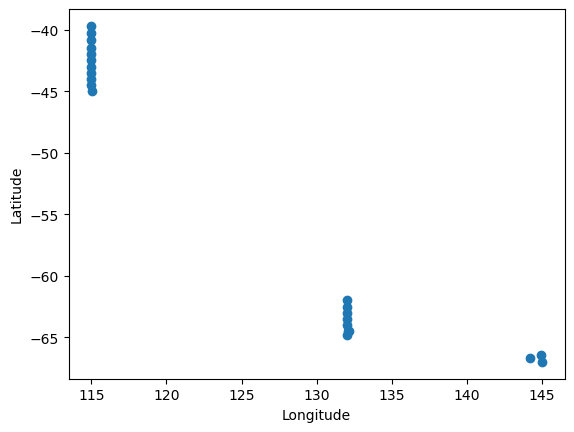

In [17]:
plt.scatter(lon, lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

We can do better than that! Although technically correct, it would be ideal to have a map instead of an empty plot, where we can see the continents. Otherwise it is hard to understand these locations without any reference points.

We will create a map using the `cartopy` library. `cartopy` is great. It allows to easily plot maps with a lot of [different projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) with a lot of customization possible to get a better-looking map with which to showcase your data in the most effective way.

We will use the `PlateCarree` projection, defined in the `fig.add_subplot(projection)` line. 

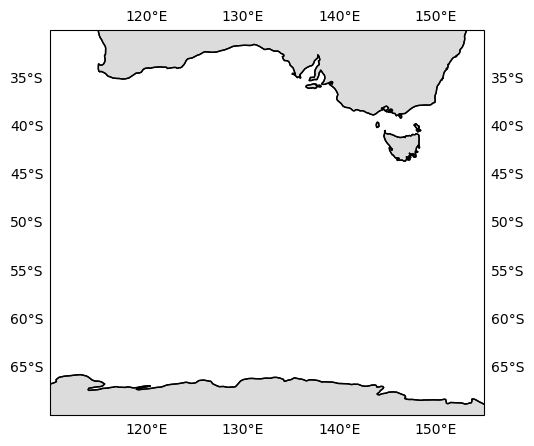

In [7]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

#### Question 1

Try [other projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) from `cartopy`, see if you can change the colour of the land, etc. Which one do you think is more appropriate to use in this case?

*Answer here*

Our map looks great, but we can make it even better. Let's plot the ocean's bathymetry in the background, to have topographic features (such as mid-ocean ridges) as reference. 

First open the bathymetry file:

In [18]:
bathymetry = xr.open_dataset('data/ETOPO_2022_v1_bed.nc')

And now we can copy the code above we used to create the map, and on top plot the bathymetry - called `z` in our `bathymetry` dataset. Note a couple of things in our plotting function:

 - We are using `pcolormesh`. You can take a look at other plotting options [here](https://matplotlib.org/stable/gallery/index.html#images-contours-and-fields).
 - There is a `transform = ccrs.PlateCarree()` argument. When plotting using `cartopy`, this **always** has to be there, independently of the `projection` defined in the subplot. Otherwise, your map will fail. 

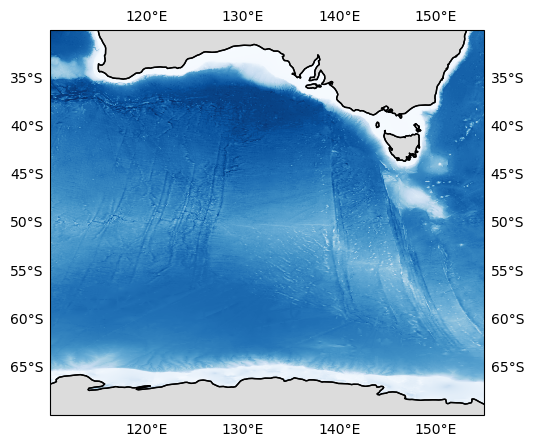

In [20]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());

#### Question 2

In the figure below, we have replaced `pcolormesh` by `contourf`. What is the difference? Which one do you think is better and why?

*Answer here*

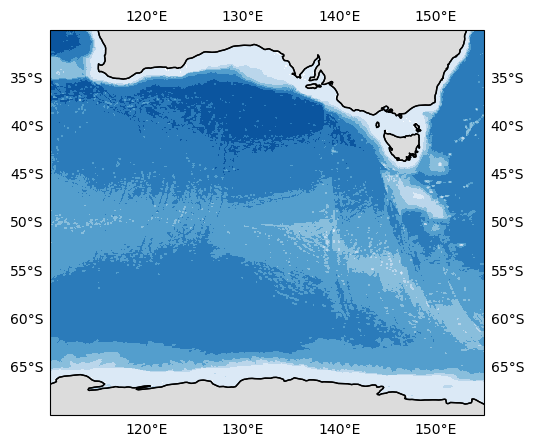

In [21]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

bathymetry['z'].plot.contourf(ax = ax, add_colorbar = False, 
                              cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                              transform = ccrs.PlateCarree());

Now that we are satisfied with our map, we can plot the location of our CTD stations. We will do this with a `scatter` plot, which uses markers for each of our `lon`, `lat` pairs. There's a lot of customization that can be done to the markers, but we will start by plotting the locations with red crosses. Remember the `transform = ccrs.PlateCarree()` argument within your plotting function!

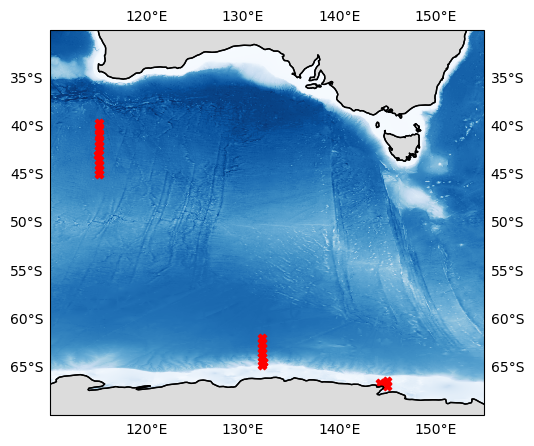

In [10]:
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0)
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());

ax.scatter(lon, lat, marker = 'X', color = 'red', transform = ccrs.PlateCarree());

This is awesome! 

We can see that a little group of profiles was taken at the Antarctic continental shelf, near the Mertz Glacier. This is a cool location, where around 10 years ago there used to be a glacier "tongue", extending from the land onto the ocean... until it was hit by a giant iceberg of 100km by 40km in size. The collision "calved", or broke off, the glacier tongue, which then became stuck in a shallow depth nearby. You can see satellite images of the calving event [here](https://earthobservatory.nasa.gov/images/42819/collision-calves-iceberg-from-mertz-glacier-tongue-antarctica).

Another group of CTD profiles were taken closer to 130E, not quite at the continental shelf, but still very close to Antarctica. And then we have a larger group of profiles up nort, closer to Western Australia. 

We can tweak our map, colouring each station differently, for example by date, to tease them apart. For that we will use a colormap. We will use the default one, `viridis`, but there are many options available. You can view and choose a colormap [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html). **Remember to choose colorblind friendly ones. `jet` is a popular colormap, but a terrible choice regarding colorvision.**

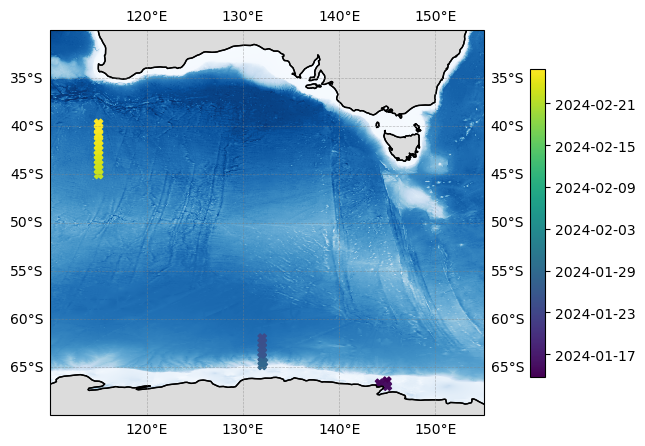

In [107]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(projection = ccrs.PlateCarree(central_longitude = 130))
ax.set_extent([110, 155, -70, -30], crs = ccrs.PlateCarree())
ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gainsboro'))
ax.coastlines(resolution = "50m")
gl = ax.gridlines(draw_labels = True, linewidth = 0.5, color = 'gray', alpha = 0.5, linestyle = '--')
gl.xformatter = ccrs.cartopy.mpl.ticker.LongitudeFormatter()
gl.yformatter = ccrs.cartopy.mpl.ticker.LatitudeFormatter()

bathymetry['z'].plot.pcolormesh(ax = ax, add_colorbar = False, 
                                cmap = 'Blues_r', vmax = 0.1, vmin = -6000,
                                transform = ccrs.PlateCarree());

loc_plot = ax.scatter(lon, lat, c = time, marker = 'X', cmap = 'viridis', transform = ccrs.PlateCarree());
# Create a colorbar with the appropriate ticks!
cbar = plt.colorbar(loc_plot, shrink = 0.8)
ticks = cbar.get_ticks()
tick_labels = [pd.to_datetime(tick).date() for tick in ticks]
cbar.set_ticks(ticks[1:-1])
cbar.set_ticklabels(tick_labels[1:-1])

Note that the creation of the colorbar and its ticks is a bit involved. This is because we are working with `datetime` format which is not always easy to use when plotting. If you want, use [CoPilot](https://copilot.microsoft.com/) to understand what each line does! 

## Plot the data

Now that we know a bit when and where these CTD profiles where taken, let's try different ways of visualising the observations. Let's start by calculating potential densities using the `gsw` library and doing a similar figure to the one in `Introduction_to_CTDs.ipynb`.

We will continue using dictionaries to avoid issues due to the varying depths between stations.

In [109]:
temperature = {}; salinity = {}; density = {}
absolute_salinity = {}; conservative_temperature = {}
for i in range(0, len(CTDs)):
    temperature[i] = CTDs[i]['temperature'].squeeze()
    salinity[i] = CTDs[i]['salinity'].squeeze()

    absolute_salinity[i] = gsw.SA_from_SP(salinity[i], CTDs[i]['pressure'], CTDs[i]['longitude'], CTDs[i]['latitude'])
    absolute_salinity[i] = absolute_salinity[i].squeeze()

    conservative_temperature[i] = gsw.CT_from_t(absolute_salinity[i], temperature[i], CTDs[i]['pressure'])
    conservative_temperature[i] = conservative_temperature[i].squeeze()
        
    density[i] = gsw.sigma0(absolute_salinity[i], conservative_temperature[i])
    density[i] = density[i].rename('density')

Now let's plot temperature, salinity and density as a function of depth:

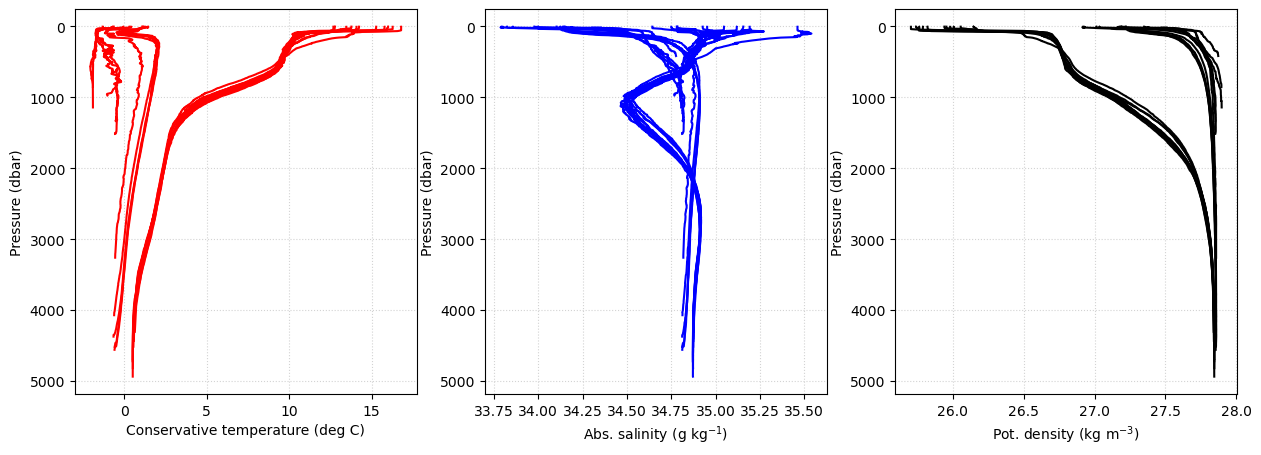

In [110]:
# Create a figure instance
fig = plt.figure(figsize = (15,5))
# Add three axes to the figure
axs = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]

# Iterate through profiles to plot
for i in range(0, len(CTDs)):
    conservative_temperature[i].plot(ax = axs[0], y = 'pressure', color = 'red', label = None)
    absolute_salinity[i].plot(ax = axs[1], y = 'pressure', color = 'blue')
    density[i].plot(ax = axs[2], y = 'pressure', color = 'k')

# Iterate through axis to add gridlines, make surface at the top, etc
for ax in axs:
    ax.grid(linestyle = ':', color = 'lightgrey')
    ax.invert_yaxis()
    ax.set_ylabel('Pressure (dbar)')   
    ax.set_title('') 

# Label each axis
axs[0].set_xlabel('Conservative temperature (deg C)')
axs[1].set_xlabel('Abs. salinity (g kg$^{-1}$)')
axs[2].set_xlabel('Pot. density (kg m$^{-3}$)');

#### Question 3

Looking at the profiles above, can you guess which ones correspond to each of the three regions on the map we made? Plot the figure but with a different color for each profile, like we did for the locations in the map.

*Answer here*

## Temperature salinity diagrams

These diagrams allows us to condense the information in the plots above in just one figure. They are made by plotting temperature as a function of salinity.

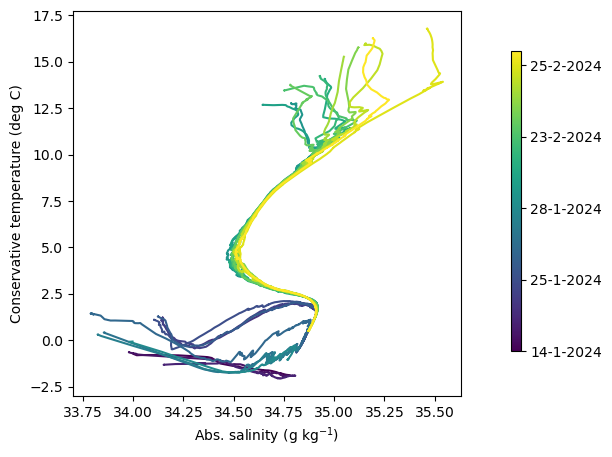

In [15]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

for i in range(0, len(CTDs)):
    ax.plot(absolute_salinity[i], conservative_temperature[i], color = colors[i])

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
cbar = plt.colorbar(mapper, cax = cax)
cbar.set_ticks(np.arange(0, len(CTDs), 5))
cbar.set_ticklabels(date[::5]);

Instead of plotting gridlines like we've been doing so far, we can plot equal density lines, which will be a useful reference. We will need to create a density array from the temperature and salinity axis in our figure.

In [16]:
temp_range = ax.get_ylim()
salt_range = ax.get_xlim()

temp_axis = np.linspace(temp_range[0], temp_range[1], 50)
salt_axis = np.linspace(salt_range[0], salt_range[1], 50)

temp_axis, salt_axis = np.meshgrid(temp_axis, salt_axis)
density_reference = gsw.sigma0(salt_axis, temp_axis)

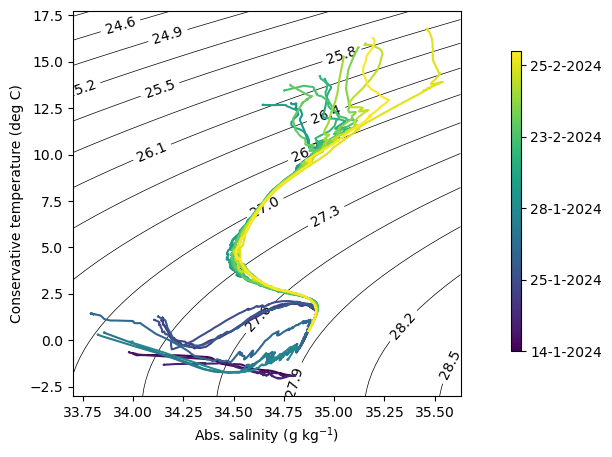

In [17]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

pref = ax.contour(salt_axis, temp_axis, density_reference, levels = 15, 
                  colors = ['k'], linewidths = [.5], zorder = 0)
plt.clabel(pref, inline = True, zorder = 0)

for i in range(0, len(CTDs)):
    ax.plot(absolute_salinity[i], conservative_temperature[i], color = colors[i])

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
cbar = plt.colorbar(mapper, cax = cax)
cbar.set_ticks(np.arange(0, len(CTDs), 5))
cbar.set_ticklabels(date[::5]);

#### Question 2

Can you identify which regions in the TS plot are stabily stratified and which ones aren't?

*Answer here*

### Making TS diagrams even better

Instead of coloring the profiles by date, we really choose any variable to color with. For that, I have asked [CoPilot](https://copilot.microsoft.com/) to help me with the following prompt:

*"I want to do a line plot with pyplot, where I am plotting X vs Y, and I'd like the line to be colored according to a third variable Z with max and min colors defined by me. How can I do that?"*

This was the answer:

```
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Example data (replace with your own)
x = np.arange(10)  # X values
y = np.random.rand(10)  # Y values
Z = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])  # Third variable (Z)

# Normalize Z to [0, 1]
normalized_Z = (Z - np.min(Z)) / (np.max(Z) - np.min(Z))

# Choose a colormap (e.g., 'jet')
colormap = cm.jet

# Create the line plot with colored segments
fig, ax = plt.subplots()
for i in range(len(x) - 1):
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], c=colormap(normalized_Z[i]))

# Add a colorbar
im = ax.scatter(x, y, c=normalized_Z, s=0, cmap=colormap)
fig.colorbar(im)

# Customize other plot settings (labels, title, etc.)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Line Plot with Colored Segments")

plt.show()

```

The above works well for one profile, but we can tweak it to work for our iteration through multiple profiles:

In [43]:
# Define min (surface) and max (largest depth I want to appear in my colormap):
vmin = 0
vmax = 4000
colormap = plt.get_cmap('jet_r')

Now we are ready to plot:

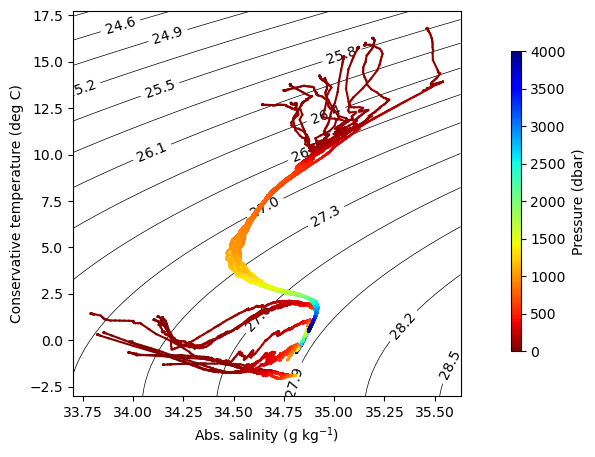

In [44]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot()

pref = ax.contour(salt_axis, temp_axis, density_reference, levels = 15, 
                  colors = ['k'], linewidths = [.5], zorder = 0)
plt.clabel(pref, inline = True, zorder = 0)

for i in range(0, len(CTDs)):
    normalized_pressure = (CTDs[i]['pressure'] - vmin) / (vmax - vmin)

    for p in range(len(CTDs[i]['pressure']) - 1):
        ax.plot([absolute_salinity[i][p], absolute_salinity[i][p + 1]], 
                [conservative_temperature[i][p], conservative_temperature[i][p + 1]], 
                c = colormap(normalized_pressure[p]))

ax.set_xlabel('Abs. salinity (g kg$^{-1}$)')
ax.set_ylabel('Conservative temperature (deg C)');

# Let's create a scatter with no markers (setting size s = 0) for the colorbar
im = ax.scatter(np.linspace(34, 35, vmax), np.linspace(0, 15, vmax), 
                c = np.arange(vmin, vmax, 1), s = 0, cmap = colormap)

cax = fig.add_axes([1.0, 0.2, 0.02, 0.6])
cbar = plt.colorbar(im, cax = cax)
cbar.set_ticks(np.arange(vmin, vmax+500, 500))
cbar.set_label('Pressure (dbar)');

#### Question 3

**a.** The colormap we used for the plot above, `jet`, is not colorblind friendly. Check out [`cmocean`](https://matplotlib.org/cmocean/) and choose a better colormap.

**b.** Instead of colouring by pressure, look at what other variables our CTD profiles have, and choose another (i.e. oxygen, nutrients). Play around with `vmin`, `vmax` to get the most out of your plot, choose different colormaps, etc.

*Answer here*